## Importing libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro

sns.set_style("ticks")

## 1. Data processing

At the begining I am going to:
- import the data
- check the data types 
- verify if there are any missing values
- examine if the **Survided** column is imbalanced.

In [2]:
# Data frame
df_train = pd.read_csv("./data/train.csv")
# Pasangers number
print(f"Number of passangers in train dataset: {df_train.shape[0]}")
df_train.head()

Number of passangers in train dataset: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Data types
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
# Check for imbalanced data
df_train["Survived"].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Data seems to be just a little imbalanced.

[Stratified-K-Fold cross-validator](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) will be used in the modeling:

![SKF](./data/Figures/SKF.png)

In [5]:
# Checking if there are any missing values:
def missing(data_frame: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame.from_dict({column : [number, percent] for column, number, percent in 
                                 zip(data_frame.columns, 
                                     data_frame.isna().sum().values, 
                                     ((data_frame.isna().sum().values) / data_frame.shape[0] * 100).round(2))}, 
                                     orient="index", columns=["number", "%"])
    return df

missing(data_frame=df_train)

,number,%
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


It occurs that we miss 77.1%, 19.87%, and 0.22% for **Cabin**, **Age** and **Embarked**, respectively.

### 1.1. Age - cleaning

In case of Age column, there is ~20% of missing values.

In [6]:
print("The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.")

if shapiro(df_train["Age"].dropna())[1] < 0.05:
    print("Age deviates from the normal distribution.")
else:
    print("Age derives from the normal distribution.")

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
Age deviates from the normal distribution.


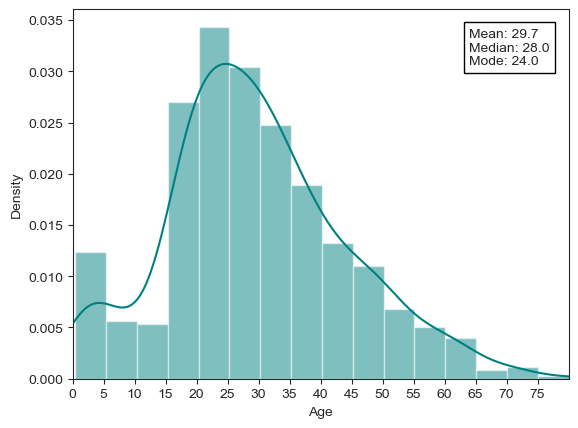

In [7]:
# Ploting a histogram of Age
def histogram(column: str, xlim: tuple[int], xticks: tuple[int], bins: int) -> None:
    ax = df_train[column].hist(bins=16, density=True, color="teal", alpha=0.5, stacked=True, grid=False)
    df_train[column].plot(kind="kde", color="teal")

    plt.xlabel(column)
    plt.xlim(*xlim)
    plt.xticks(np.arange(*xticks))

    mean = df_train[column].mean(skipna=True).round(2)
    median = df_train[column].median(skipna=True).round(2)
    mode = df_train[column].mode().values[0].round(2)

    plt.text(transform=ax.transAxes,
            horizontalalignment='left',
            bbox=dict(edgecolor="black", fill=False),
            x=0.8, y=0.85,
            s=f"Mean: {mean}\nMedian: {median}\nMode: {mode}")

    plt.show()

histogram(column="Age", xlim=(0, 80), xticks=(0, 80, 5), bins=16)

I will fill the missing values with the median.

### 1.2. Cabin - cleaning

~77% of cabin values in missing. It is better to exclude this variable from the analysis.

### 1.3. Embarked - cleaning

In case of embarking place, only ~0.2% of values in missing (2 persons).

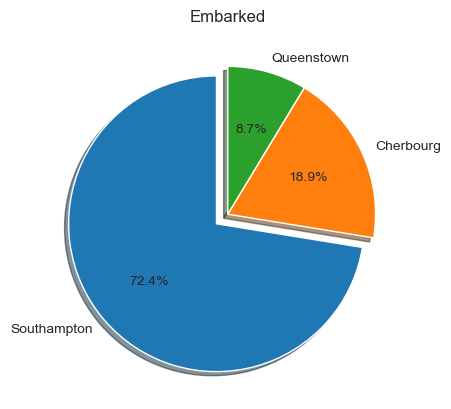

In [8]:
embarking = df_train["Embarked"].value_counts(normalize=True) * 100

embarking.plot(kind="pie", labels=["Southampton", "Cherbourg", "Queenstown"], ylabel="", title="Embarked", autopct="%1.1f%%", 
               explode=(0.1, 0, 0), shadow=True, startangle=90)
plt.show()

I will fill those gaps with Southampton (S) port.

### 1.4. Data adjustment

In [9]:
df_train_clean = df_train.copy() # Clean copy of the data frame.

df_train_clean["Age"].fillna(df_train["Age"].median(), inplace=True) # Adjusting the Age column.
df_train_clean["Embarked"].fillna("S", inplace=True) # Adjusting the Embarked column.
df_train_clean.drop(columns="Cabin", inplace=True)  # Removing the Cabin column since it misses 77% of the values.

# Confirming
df_train_clean.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

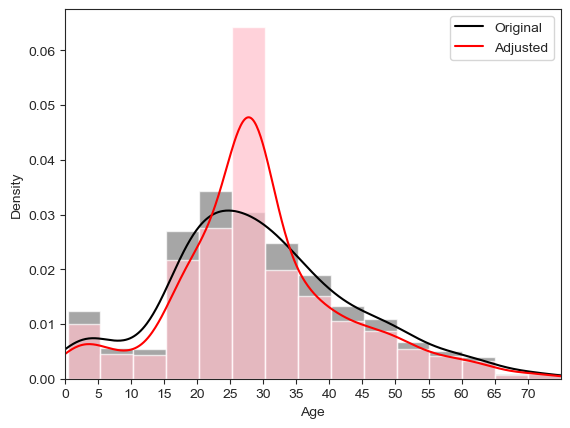

In [10]:
# Checking how the distribution of Age was influenced
df_train["Age"].hist(bins=16, density=True, stacked=True, color='grey', alpha=0.7)
df_train["Age"].plot(kind="kde", color="black")

df_train_clean["Age"].hist(bins=16, density=True, stacked=True, color='pink', alpha=0.7)
df_train_clean["Age"].plot(kind="kde", color="red")

plt.xlim(0, 75)
plt.xticks(np.arange(0, 75, 5))
plt.xlabel("Age")
plt.legend(['Original', 'Adjusted'])

plt.show()

### 2. Feature Engineering

As per the Kaggle data dictionary, both SibSp and Parch pertain to the concept of traveling with family, I will merge them to one categorical varible: **TavelAlone**

- sibsp - # of siblings / spouses aboard the Titanic
- parch	# of parents / children aboard the Titanic

Next I will remove "PassengerId", "Name", "Ticket", "SibSp", "Parch" columns as they shoud have negligible effect on the survival variable.

In [11]:
# Creating a TravelAlone predictor.
df_train_clean['TravelAlone'] = np.where((df_train_clean["SibSp"] + df_train_clean["Parch"]) > 0, 0, 1)

Columns **SibSp**, **Parch** will be removed since we transformed them into one predictor: **TravelAlone**.

Columns **PassengerId**, **Name**, **Ticket** will be removed since they have negligible affect on the survival.

In [12]:
# Removing irrelevant columns
df_train_clean.drop(columns=["PassengerId", "Name", "Ticket", "SibSp", "Parch"], inplace=True)
df_train_clean.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


I will convert the data types and ensure that that numerical columns have no empty spaces.

In [13]:
df_train_clean.dtypes

Survived         int64
Pclass           int64
Sex             object
Age            float64
Fare           float64
Embarked        object
TravelAlone      int64
dtype: object

In [14]:
df_train_clean[['Survived', 'Pclass', 'Age', 'Fare', 'TravelAlone']] = df_train_clean[['Survived', 'Pclass', 'Age', 'Fare', 'TravelAlone']].astype("int32")
df_train_clean['Fare'] = df_train_clean['Fare'].astype("float32")
df_train_clean.dtypes

Survived         int32
Pclass           int32
Sex             object
Age              int32
Fare           float32
Embarked        object
TravelAlone      int32
dtype: object

In [15]:
for column in ['Survived', 'Pclass', 'Sex', 'Embarked', 'TravelAlone']:
    print(column, df_train_clean[column].unique())

Survived [0 1]
Pclass [3 1 2]
Sex ['male' 'female']
Embarked ['S' 'C' 'Q']
TravelAlone [0 1]


When dealing with predictor variables that denote categories, like passenger class (1, 2, 3), it is advisable to consider them as categorical variables instead of numerical ones. Categorical variables encompass a finite and typically predetermined set of values, signifying distinct categories or groups. Regarding passenger class, treating it as a continuous variable is inappropriate due to the lack of meaningful interpretation for the numerical differences between classes.

When creating dummy variables for categorical data, it is a common practice to use the "dummy variable trap" technique, which involves dropping one of the dummy variables. This is done to avoid multicollinearity issues in statistical models.

I intend to generate categorical classes based on the **Pclass**, **Embarked**, and **Sex**

In [16]:
# Creating categorical predictors. 
df_train_encoded = pd.get_dummies(df_train_clean, columns=["Pclass","Embarked","Sex"], drop_first=True, dtype=int)
df_train_encoded.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22,7.0,0,0,1,0,1,1
1,1,38,71.0,0,0,0,0,0,0
2,1,26,7.0,1,0,1,0,1,0
3,1,35,53.0,0,0,0,0,1,0
4,0,35,8.0,1,0,1,0,1,1


- 'utilities.transform.data_adjustment' will be used to prepare the data for model building. 
- For EDA dataframe 'df_train_clean' will be used.

## 3. Explanatory Data Analysis (**EDA**)

to be continuted ...

### 3.1. Age

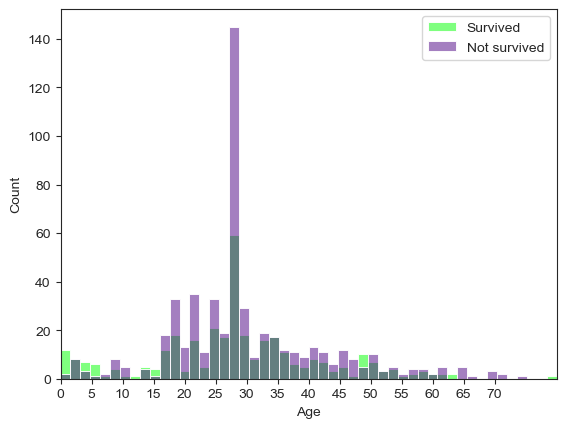

In [17]:
sns.histplot(data=df_train_clean, x="Age", hue="Survived", palette={0:"indigo", 1:"lime"}, fill=True, bins=50)
plt.legend(["Survived", "Not survived"])
plt.xlim(0,80)
plt.xticks(np.arange(0, 75, 5))
plt.show()

### 3.2. Fare

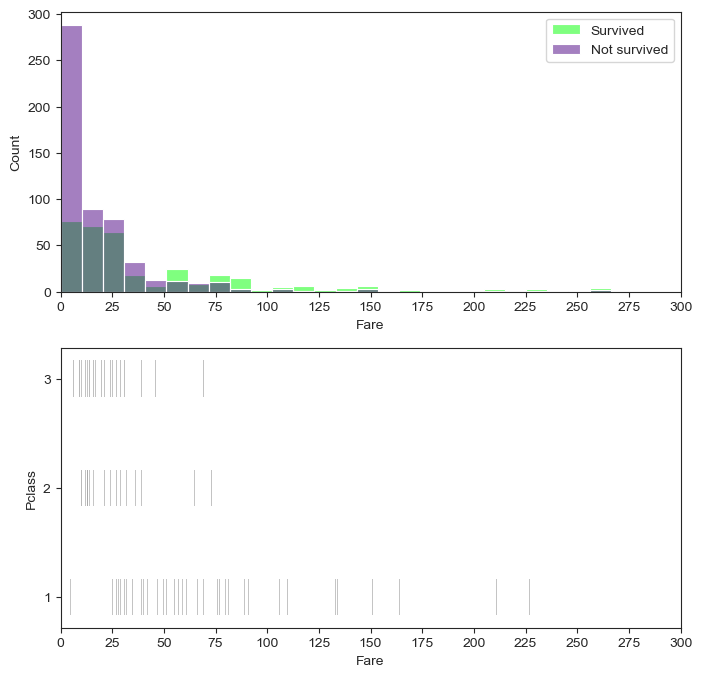

In [18]:
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(8,8))

ax = axes[0]
sns.histplot(data=df_train_clean, x="Fare", hue="Survived", palette={0:"indigo", 1:"lime"}, fill=True, bins=50, ax=ax)
ax.legend(["Survived", "Not survived"])
ax.set_xlim(0,300)
ax.set_xticks(np.arange(0, 325, 25))

ax = axes[1]
sns.histplot(data=df_train_clean, x="Fare", y="Pclass",  ax=ax, color="black", binwidth=(0.3))
ax.set_xlim(0,300)
ax.set_xticks(np.arange(0, 325, 25))
ax.set_yticks([1.15, 2.05, 2.95], ["1", "2", "3"])

plt.show()

In [19]:
df_train[(df_train["Fare"] < 25) & (df_train['Pclass'] == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S


[Harrison, Mr. William](https://www.encyclopedia-titanica.org/titanic-victim/william-harrison.html)